In [1]:
import os
import scanpy
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import re
import tqdm
import sklearn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from collections import Counter
import random
import seaborn
import sys
import shutil
import scvelo as scv
import bbknn
#Load my pipeline functions
import importlib
import importlib.util
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("../../utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)
spec.loader.exec_module(sc_utils)
sc.settings.figdir='/wynton/group/ye/mtschmitz/figures/geo/'
scv.settings.figdir='/wynton/group/ye/mtschmitz/figures/geo/'
sc.settings.file_format_figs='pdf'
sc.settings.autosave=False
sc.settings.autoshow=True
import matplotlib.font_manager
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Nimbus Sans','Arial']})
matplotlib.rc('text', usetex=False)
scanpy.set_figure_params(scanpy=True,dpi_save=300)


In [26]:
adata=sc.read('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMacaqueGeAllcortexHippocampusProcessed.h5ad')

In [90]:
%matplotlib inline
adata

AnnData object with n_obs × n_vars = 109111 × 27454
    obs: 'batch', 'batch_name', 'file_name', 'timepoint', 'region', 'class', 'hires_leiden', 'leiden', 'n_genes', 'latent_cell_probability', 'phase', 'latent_time', 'n_counts'
    var: 'feature_type-0', 'id-0', 'mean', 'std'
    uns: 'batch_name_colors', 'class_colors', 'classes', 'classname_colors', 'dendrogram_noctx_supervised_name', 'general_region_colors', 'hvg', 'leiden', 'leiden_colors', 'marker_groups', 'neighbors', 'noctx_supervised_name_colors', 'pca', 'phase_colors', 'region_colors', 'regions', 'subclassname_colors', 'supervised_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

... storing 'region' as categorical


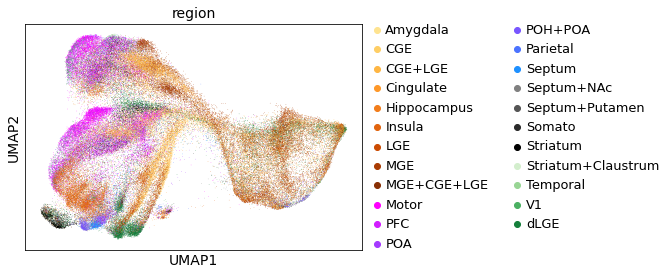

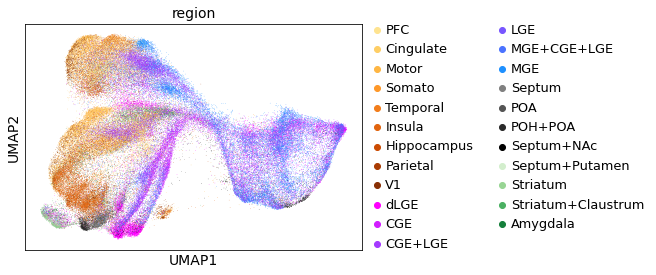

In [29]:
sc.pl.umap(adata,color='region')
cortex_order=['pfc','cingulate','motor','somato','temporal','insula','hippocampus','parietal','v1']
cortex_colors=seaborn.color_palette("YlOrBr",n_colors=len(cortex_order)+2).as_hex()[2:]
ventral_tel=['ge','cge', 'cge_and_lge', 'lge','mge_and_cge_and_lge', 'mge']
vt_colors=seaborn.blend_palette(('fuchsia','dodgerblue'),n_colors=len(ventral_tel)).as_hex()
med_tel=['septum','pre-optic', 'hypothalamusandpoa','septumandnucleusaccumbens']
mt_colors=seaborn.blend_palette(('grey','black'),n_colors=len(med_tel)).as_hex()
basal_gang=['putamen_and_septum','str', 'putamenandclaustrumandbasalganglia', 'amy']
bg_colors=seaborn.color_palette("Greens",n_colors=len(basal_gang)).as_hex()

all_regions=cortex_order+ventral_tel+med_tel+basal_gang
all_regions_colors=cortex_colors+vt_colors+mt_colors+bg_colors

all_regions_dict={'pfc':'PFC',
 'cingulate':'Cingulate',
 'motor':'Motor',
 'somato':'Somato',
 'temporal':'Temporal',
 'insula':'Insula',
 'hippocampus':'Hippocampus',
 'parietal':'Parietal',
 'v1':'V1',
 'cge':'CGE',
 'cge_and_lge':'CGE+LGE',
 'lge':'LGE',
 'mge_and_cge_and_lge':'MGE+CGE+LGE',
 'mge':'MGE',
 'septum':'Septum',
 'ge':'dLGE',
 'xLGE':'dLGE',
 'pre-optic':'POA',
 'hypothalamusandpoa':'POH+POA',
 'septumandnucleusaccumbens':'Septum+NAc',
 'putamen_and_septum':'Septum+Putamen',
 'str':'Striatum',
 'putamenandclaustrumandbasalganglia':'Striatum+Claustrum',
 'amy':'Amygdala'}
all_regions=[all_regions_dict[x] for x in all_regions]
cortex_order=[all_regions_dict[x] for x in cortex_order]
region_color_dict=dict(zip(all_regions,all_regions_colors))

adata.obs['region']=adata.obs['region'].replace(all_regions_dict)
adata.obs['region']=adata.obs['region'].astype('category')
adata.obs.region.cat.reorder_categories(all_regions,inplace=True,ordered=True)
adata.uns['region_colors']=all_regions_colors

sc.pl.umap(adata,color='region')

In [30]:
supercell=pd.read_csv('/wynton/group/ye/mtschmitz/macaquedevbrain/MacaqueGEsupervisednamesHippo3PreserveCompoundname.txt')
ind=adata.obs.index[adata.obs.index.isin(supercell['full_cellname'])]
supercell.index=supercell['full_cellname']
supercell=supercell.loc[ind,:]
adata.obs.loc[ind,'supervised_name']=supercell['supervised_name']
adata.obs.loc[ind,'hires_leiden']=supercell['leiden']
adata.obs['supervised_name']=adata.obs['supervised_name'].astype(str)
adata.obs['supervised_name']=[re.sub('Cortical ','',x) for x in adata.obs['supervised_name'] ]
adata.obs['supervised_name']=adata.obs['supervised_name'].astype('category')
adata.obs['noctx_supervised_name']=adata.obs['supervised_name']


In [35]:
obs=adata.obs

In [32]:
supercell=pd.read_csv('/wynton/group/ye/mtschmitz/macaquedevbrain/MacaqueGEsupervisednamesHippoPredictedEnd.txt')
ind=adata.obs.index[adata.obs.index.isin(supercell['full_cellname'])]
supercell.index=supercell['full_cellname']
supercell=supercell.loc[ind,:]
adata.obs['latent_time']=np.nan
adata.obs['predicted_end']=''
adata.obs.loc[ind,['noctx_supervised_name','predicted_end','latent_time']]=supercell.loc[:,['noctx_supervised_name','predicted_end','latent_time']]
adata.obs.loc[adata.obs['predicted_end'].isna(),'noctx_supervised_name']=adata.obs['noctx_supervised_name'][adata.obs['predicted_end'].isna()]

In [33]:
pd.DataFrame(adata.obsm['X_umap']).to_csv(os.path.expanduser('~/MacaqueUMAP.csv'))

In [38]:
adata.obs['intronic_umi']=adata.layers['unspliced'].sum(1)
adata.obs['exonic_umi']=adata.layers['spliced'].sum(1)
adata.obs['umi_per_cell']=adata.obs['intronic_umi']+adata.obs['exonic_umi']
adata.obs['percent_introns']=adata.obs['intronic_umi']/adata.obs['umi_per_cell']
adata.obs['percent_exons']=adata.obs['exonic_umi']/adata.obs['umi_per_cell']


In [39]:
adata.obs.loc[:,['batch','timepoint','region','file_name','supervised_name','leiden','n_genes','latent_cell_probability','phase','latent_time','intronic_umi','exonic_umi','umi_per_cell','percent_introns','percent_exons']].to_csv(os.path.expanduser('~/MacaqueCellMetadata.csv'))

In [28]:
adata.obs=adata.obs.loc[:,['batch','batch_name','file_name','timepoint','region','supervised_name','hires_leiden','leiden','n_genes','latent_cell_probability','phase','latent_time']]

In [29]:
import json
filenames=[]
jsons=[]
for root, dirs, files in os.walk('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto', topdown=True):
    dirs[:] = [d for d in dirs if '_Out' not in d]
    for name in files:
        if name =='run_info.json':
            print(root)
            filenames.append(root)
            f=open(os.path.join(root, name))
            jsons.append(json.load(f))
            f.close()

jsonframe=pd.DataFrame(jsons)
jsonframe.index=[x.split('/')[-1] for x in filenames]
jsonframe=jsonframe.loc[jsonframe.index.isin(adata.obs['file_name'].unique()),:]

/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/PEC_Yale_SingleCellRNAseq_RMB683_MD_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E90-2019_V1_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E65-2019B_V1_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/PEC_Yale_SingleCellRNAseq_RMB691_DFC_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E50_motor_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/PEC_Yale_SingleCellRNAseq_RMB691_AMY_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E80-2019_Cerebellum_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E80temporal_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E65-2019A_Temporal_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E50_choroid_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E40_thalamus_kOut
/wynton/group/ye/mtschmitz/macaquedevbrain

In [30]:
jsonframe.drop(columns=['n_targets','n_bootstraps','start_time','call']).to_csv(os.path.expanduser('~/MacaqueSampleMetadata.csv'))

In [31]:
adata.obs=adata.obs.rename(columns={'supervised_name':'class'})

In [32]:
adata.var=adata.var.loc[:,['feature_type-0','id-0']]

In [33]:
adata.uns['class_colors']=adata.uns['noctx_supervised_name_colors']

In [34]:
adata.uns['regions']=list(adata.obs.region.cat.categories)
adata.uns['classes']=list(adata.obs['class'].cat.categories)

In [35]:
adata.obs

batch   batch_name         file_name  timepoint  \
CTCAGTCGTCCGGTGT_E90-2019_V1     0  E90-2019_V1  E90-2019_V1_kOut       90.0   
CAGCGTGGTGAGTAAT_E90-2019_V1     0  E90-2019_V1  E90-2019_V1_kOut       90.0   
TATGTTCTCACCTGGG_E90-2019_V1     0  E90-2019_V1  E90-2019_V1_kOut       90.0   
ATTTACCCACCGTCTT_E90-2019_V1     0  E90-2019_V1  E90-2019_V1_kOut       90.0   
CATACCCTCATTGTGG_E90-2019_V1     0  E90-2019_V1  E90-2019_V1_kOut       90.0   
...                            ...          ...               ...        ...   
GACTGCGAGGCATGGT_E40_V1         90       E40_V1       E40_V1_kOut       40.0   
GTGTTAGCAAAGTCAA_E40_V1         90       E40_V1       E40_V1_kOut       40.0   
AGCGGTCAGCGTGAGT_E40_V1         90       E40_V1       E40_V1_kOut       40.0   
ATCTACTCAGCGAACA_E40_V1         90       E40_V1       E40_V1_kOut       40.0   
CATATGGAGCTGATAA_E40_V1         90       E40_V1       E40_V1_kOut       40.0   

                             region            class  hires_leiden leiden  \
CTCAGTCGTCCGGTGT_E90-2019_V1     V1     MGE_LHX6/MAF            41     17   
CAGCGTGGTGAGTAAT_E90-2019_V1     V1  CGE_NR2F2/PROX1            46     18   
TATGTTCTCACCTGGG_E90-2019_V1     V1     MGE_LHX6/MAF            87     18   
ATTTACCCACCGTCTT_E90-2019_V1     V1     MGE_LHX6/MAF            55     14   
CATACCCTCATTGTGG_E90-2019_V1     V1     MGE_LHX6/MAF            57      6   
...                             ...              ...           ...    ...   
GACTGCGAGGCATGGT_E40_V1          V1  LGE_FOXP2/TSHZ1             7     36   
GTGTTAGCAAAGTCAA_E40_V1          V1   RMTW_ZIC1/RELN            59     24   
AGCGGTCAGCGTGAGT_E40_V1          V1   RMTW_ZIC1/RELN            59     41   
ATCTACTCAGCGAACA_E40_V1          V1   RMTW_ZIC1/RELN            59     41   
CATATGGAGCTGATAA_E40_V1          V1   RMTW_ZIC1/RELN            59     41   

                              n_genes  latent_cell_probability phase  \
CTCAGTCGTCCGGTGT_E90-2019_V1     2662                 0.999933    G1   
CAGCGTGGTGAGTAAT_E90-2019_V1     3054                 0.999963    G1   
TATGTTCTCACCTGGG_E90-2019_V1     2007                 0.999916    G1   
ATTTACCCACCGTCTT_E90-2019_V1     2444                 0.999930    G1   
CATACCCTCATTGTGG_E90-2019_V1     2368                 0.999911    G1   
...                               ...                      ...   ...   
GACTGCGAGGCATGGT_E40_V1           810                 0.999764    G1   
GTGTTAGCAAAGTCAA_E40_V1           847                 0.999612    G1   
AGCGGTCAGCGTGAGT_E40_V1           939                 0.999720    G1   
ATCTACTCAGCGAACA_E40_V1           985                 0.999613    G1   
CATATGGAGCTGATAA_E40_V1           847                 0.999677    G1   

                              latent_time  
CTCAGTCGTCCGGTGT_E90-2019_V1     0.473706  
CAGCGTGGTGAGTAAT_E90-2019_V1     0.492486  
TATGTTCTCACCTGGG_E90-2019_V1     0.626058  
ATTTACCCACCGTCTT_E90-2019_V1     0.240401  
CATACCCTCATTGTGG_E90-2019_V1     0.427126  
...                                   ...  
GACTGCGAGGCATGGT_E40_V1          0.664648  
GTGTTAGCAAAGTCAA_E40_V1          0.311454  
AGCGGTCAGCGTGAGT_E40_V1          0.323031  
ATCTACTCAGCGAACA_E40_V1          0.586690  
CATATGGAGCTGATAA_E40_V1          0.260900  

[109111 rows x 12 columns]

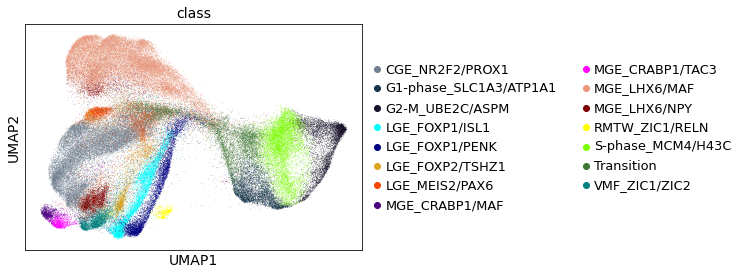

In [36]:
%matplotlib inline
sc.pl.umap(adata,color=['class'])

In [37]:
del adata.layers['ambiguous']
del adata.layers['spliced']
del adata.layers['unspliced']

In [38]:
adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]


In [ ]:
adata.write_csvs('/wynton/home/ye/mschmitz1/INcsvs/',skip_data=False)

writing .csv files to /wynton/home/ye/mschmitz1/INcsvs


In [39]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)

In [40]:
adata.write('/wynton/home/ye/mschmitz1/MacaqueDevInhibitoryNeurons.h5ad')

In [24]:
adata=sc.read('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityDYNAMICALMouseWbGe.h5ad')

In [31]:
adata.obs['clippedtp']=np.clip(adata.obs['timepoint'],0,24)

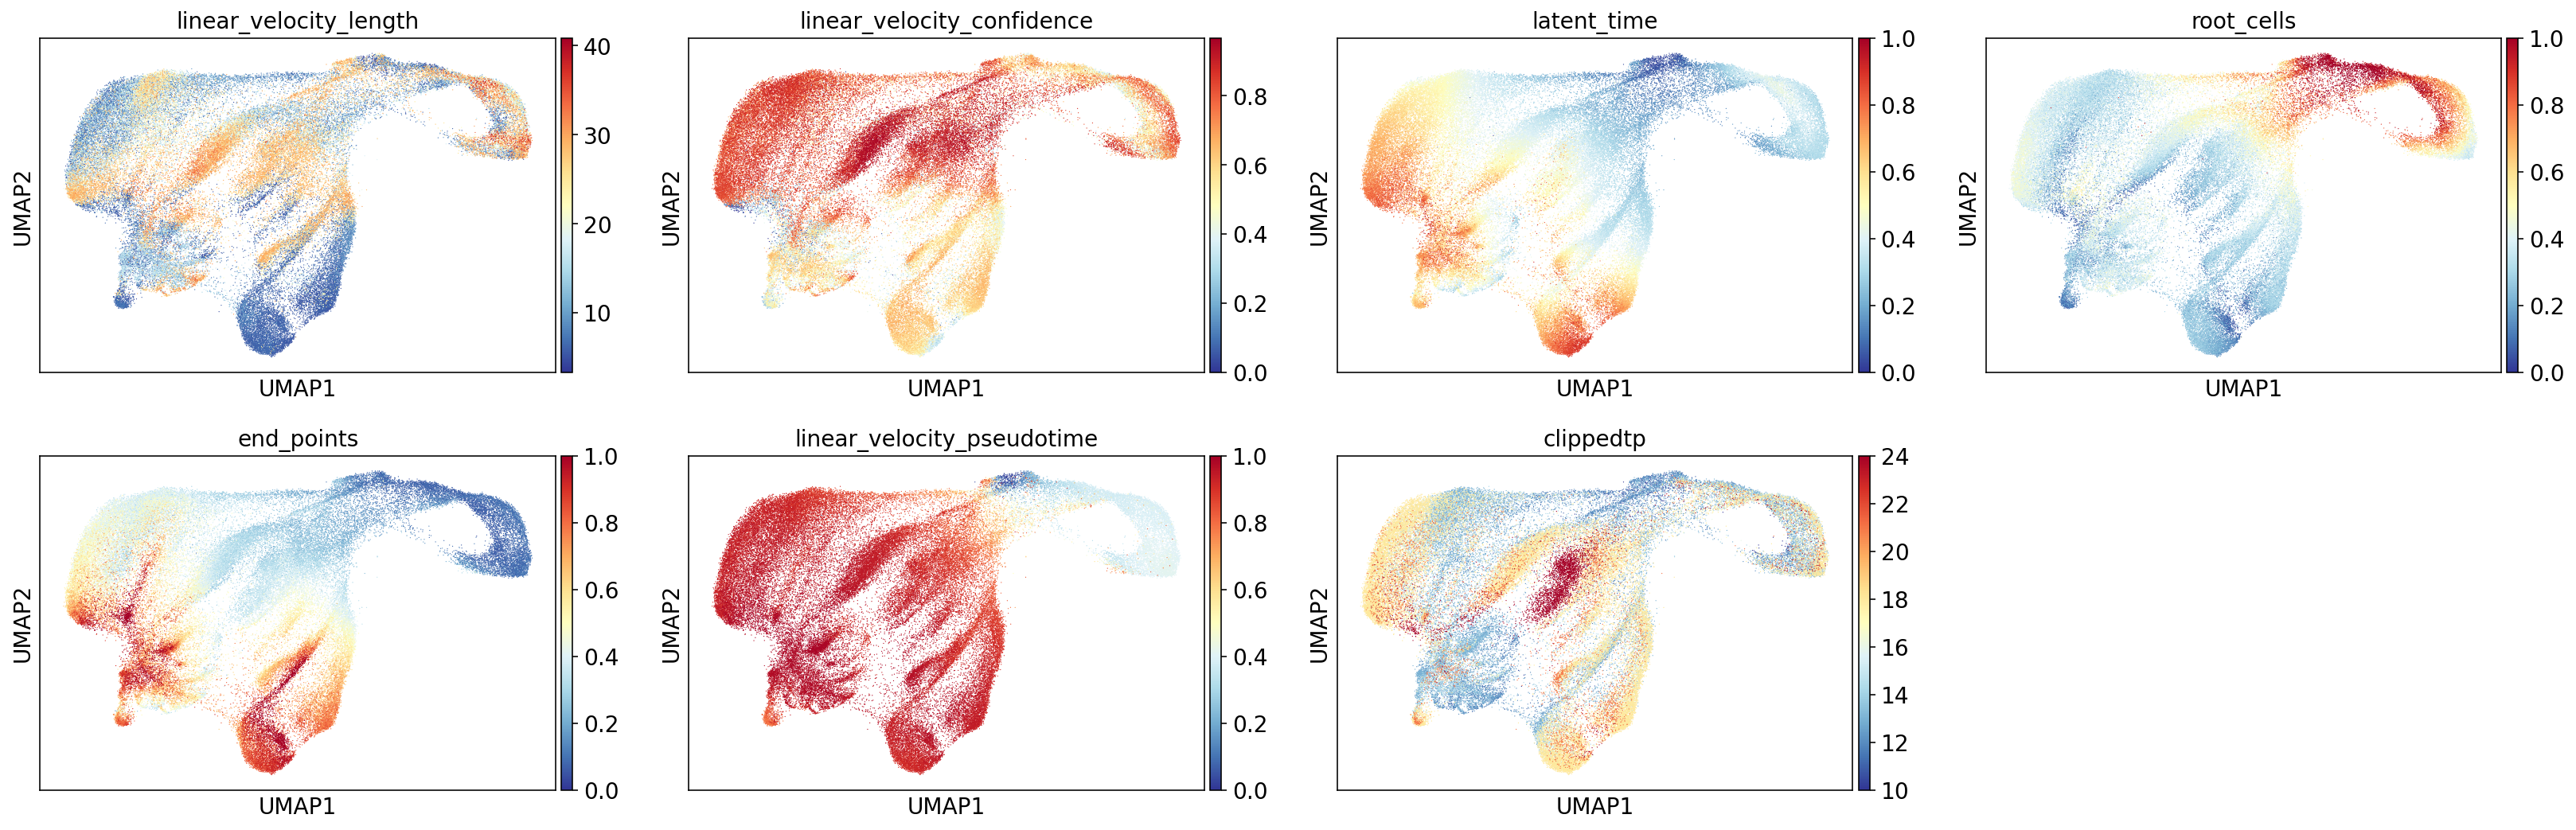

In [32]:
%matplotlib inline
sc.settings.figdir='/wynton/group/ye/mtschmitz/figures/mouseWbGeCB202002/'
scv.settings.figdir='/wynton/group/ye/mtschmitz/figures/mouseWbGeCB202002/'
sc.pl.umap(adata,color=['linear_velocity_length', 'linear_velocity_confidence','latent_time','root_cells','end_points','linear_velocity_pseudotime','clippedtp'],color_map=matplotlib.cm.RdYlBu_r,save='linear_velocity_stats')


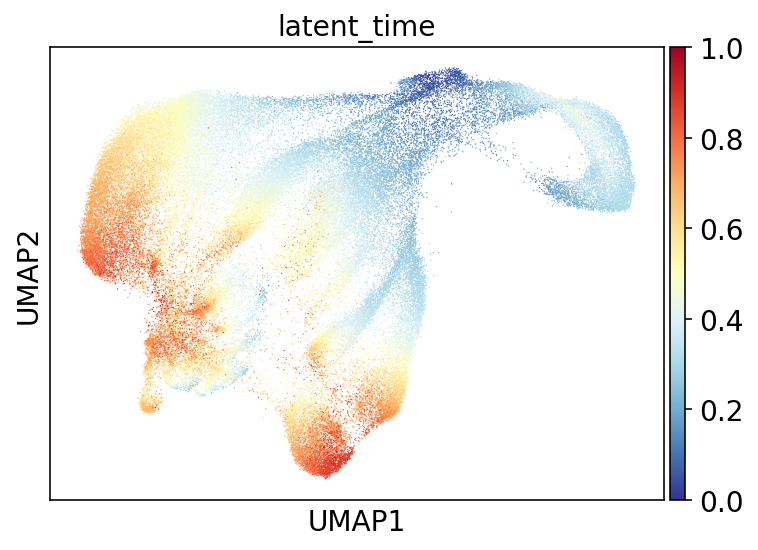

In [22]:
sc.pl.umap(adata,color=['latent_time'],color_map=matplotlib.cm.RdYlBu_r)


In [8]:
adata.obs=adata.obs.rename(columns={'supervised_name':'class'})

In [9]:
adata.obs.loc[:,['dataset_name','batch_name','timepoint','region','class','leiden','n_genes','latent_cell_probability','phase','latent_time']].to_csv(os.path.expanduser('~/MouseCellMetadata.csv'))

In [10]:
adata.obs=adata.obs.loc[:,['batch','batch_name','timepoint','region','class','old_leiden','leiden','n_genes','latent_cell_probability','phase','latent_time']]

In [11]:
adata.obs.drop('old_leiden',axis=1,inplace=True)

In [12]:
adata.var=adata.var.loc[:,['feature_type-0-0','id-0-0','name-0-0']]
adata.var.index=list(adata.var['name-0-0'])
adata.raw.var.index=list(adata.raw.var['name-0-0'])

In [13]:
adata.var

feature_type-0-0              id-0-0       name-0-0
0610005C13Rik  b'Gene Expression'  ENSMUSG00000109644  0610005C13Rik
0610006L08Rik  b'Gene Expression'  ENSMUSG00000108652  0610006L08Rik
0610009B22Rik  b'Gene Expression'  ENSMUSG00000007777  0610009B22Rik
0610009E02Rik  b'Gene Expression'  ENSMUSG00000086714  0610009E02Rik
0610009L18Rik  b'Gene Expression'  ENSMUSG00000043644  0610009L18Rik
...                           ...                 ...            ...
n-R5s82        b'Gene Expression'  ENSMUSG00000077401        n-R5s82
n-R5s88        b'Gene Expression'  ENSMUSG00000065107        n-R5s88
n-R5s95        b'Gene Expression'  ENSMUSG00000064618        n-R5s95
n-R5s96        b'Gene Expression'  ENSMUSG00000064508        n-R5s96
n-TStga1       b'Gene Expression'  ENSMUSG00000104750       n-TStga1

[34430 rows x 3 columns]

In [14]:
oldvar=adata.var

In [15]:
adata.layers

Layers with keys: Ms, Mu, spliced, unspliced

In [16]:
del adata.layers['spliced']
del adata.layers['unspliced']
del adata.layers['Ms']
del adata.layers['Mu']

In [17]:
adata.uns['regions']=list(adata.obs.region.cat.categories)
adata.uns['classes']=list(adata.obs['class'].cat.categories)

In [18]:
adata.uns['class_colors']=adata.uns['supervised_name_colors']

In [19]:
adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]

In [ ]:
adata.write_csvs('/wynton/home/ye/mschmitz1/MouseDevINcsvs/',skip_data=False)

writing .csv files to /wynton/home/ye/mschmitz1/MouseDevINcsvs


In [20]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)

In [ ]:
#adata.write_csvs('/wynton/home/ye/mschmitz1/MouseDevINcsvs/',skip_data=False)

In [21]:
adata.write('/wynton/home/ye/mschmitz1/MouseDevInhibitoryNeurons.h5ad')

In [2]:
adata=sc.read('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityDYNAMICALMouseWbGeAdult.h5ad')

In [64]:
adata=sc.read('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMouseWbGeAdult.h5ad')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [3]:
adata

AnnData object with n_obs × n_vars = 141069 × 34430
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'tp', 'batch', 'clean_cellname', 'full_cellname', 'leiden', 'supervised_name', 'percent_ribo', 'percent_mito', 'old_leiden', 'allen_cluster_label', 'allen_class_label', 'simplified_allen', 'agg_supervised_name', 'n_counts', 'cc_velocity_self_transition', 'root_cells', 'end_points', 'cc_velocity_pseudotime', 'latent_time', 'cc_velocity_length', 'cc_velocity_confidence', 'cc_velocity_confidence_transition', 'cc_latent_time', 'linear_velocity_self_transition', 'linear_velocity_pseudotime', 'linear_velocity_length', 'linear_velocity_confidence', 'linear_velocity_confidence_transition'
    var: 'feature_type-0-0', 'id-0-0', 'name-0-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-0-1', 'id-0-1', 'name-0-1', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-0-10', 'id-0-10', 'name-0-10', 'feature_type-

In [4]:
adata

AnnData object with n_obs × n_vars = 141069 × 34430
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'tp', 'batch', 'clean_cellname', 'full_cellname', 'leiden', 'supervised_name', 'percent_ribo', 'percent_mito', 'old_leiden', 'allen_cluster_label', 'allen_class_label', 'simplified_allen', 'agg_supervised_name', 'n_counts', 'cc_velocity_self_transition', 'root_cells', 'end_points', 'cc_velocity_pseudotime', 'latent_time', 'cc_velocity_length', 'cc_velocity_confidence', 'cc_velocity_confidence_transition', 'cc_latent_time', 'linear_velocity_self_transition', 'linear_velocity_pseudotime', 'linear_velocity_length', 'linear_velocity_confidence', 'linear_velocity_confidence_transition'
    var: 'feature_type-0-0', 'id-0-0', 'name-0-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-0-1', 'id-0-1', 'name-0-1', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-0-10', 'id-0-10', 'name-0-10', 'feature_type-

In [5]:
adata.layers['unspliced'].sum(1)

matrix([[1268.0001],
        [1267.9999],
        [1268.    ],
        ...,
        [1268.0001],
        [1268.0001],
        [1268.    ]], dtype=float32)

In [6]:
adata.obs['intronic_umi']=adata.layers['unspliced'].sum(1)
adata.obs['exonic_umi']=adata.layers['spliced'].sum(1)
adata.obs['umi_per_cell']=adata.obs['intronic_umi']+adata.obs['exonic_umi']
adata.obs['percent_introns']=adata.obs['intronic_umi']/adata.obs['umi_per_cell']
adata.obs['percent_exons']=adata.obs['exonic_umi']/adata.obs['umi_per_cell']


ValueError: Length of values (1) does not match length of index (141069)

In [7]:
del adata.layers['spliced']
del adata.layers['unspliced']
del adata.layers['Ms']
del adata.layers['Mu']

In [8]:
adata.obs['agg_supervised_name']='nan'
adata.obs['old_leiden']='nan'
supercell=pd.read_csv('/wynton/group/ye/mtschmitz/macaquedevbrain/MouseAdultAggSupervised.txt')
adata=adata[~adata.obs.index.duplicated(),:]
supercell=supercell.loc[supercell['agg_supervised_name']!='nan',:]
ind=adata.obs.index[adata.obs.index.isin(supercell['full_cellname'])]
supercell.index=supercell['full_cellname']
supercell=supercell.loc[~supercell.index.duplicated(),:]
supercell=supercell.loc[ind,:]
adata.obs.loc[ind,'agg_supervised_name']=supercell['agg_supervised_name']
adata.obs.loc[ind,'old_leiden']=supercell['leiden']
adata.obs['agg_supervised_name']=adata.obs['agg_supervised_name'].astype(str)
adata.obs['old_leiden']=adata.obs['old_leiden'].astype(str)
adata=adata[adata.obs['agg_supervised_name']!='nan',:]

Trying to set attribute `.obs` of view, copying.


In [9]:
adata.obs['leiden']=adata.obs['old_leiden']

Trying to set attribute `.obs` of view, copying.


In [10]:
adata.obs['region']=[re.sub('srr|samn','',x) for x in adata.obs['region'].astype(str)]
adata.obs['region']=[re.sub('ctx','cortex',x) for x in adata.obs['region'].astype(str)]
adata.obs['region']=[re.sub('ssctx','cortex',x) for x in adata.obs['region'].astype(str)]
adata.obs['region']=adata.obs.region.astype(str)
adata.obs.loc[adata.obs.region.str.contains('ltx'),'region']='cortex'
adata.obs.loc[adata.obs.region.str.contains('(?i)sscortex'),'region']='cortex'
adata.obs.loc[adata.obs.region.str.contains('dentgyr|^ca$'),'region']='hippocampus'

adata.obs['timepoint']=adata.obs['timepoint'].astype(str)
adata.obs.loc[adata.obs['dataset_name']=='PRJNA498989_OB_mouse','timepoint']=84
adata.obs.loc[adata.obs['dataset_name']=='PRJNA515751_konopka_striatum','timepoint']=30
adata.obs.loc[adata.obs['batch_name'].str.contains('P5_',case=False),'timepoint']=26
adata.obs.loc[adata.obs['batch_name'].str.contains('p07_Cortex_SRR11947654',case=False),'timepoint']=28
adata.obs.loc[adata.obs['timepoint']=='nan','timepoint']=84
adata.obs.loc[adata.obs['timepoint'].astype(float)>100,'timepoint']=84

adata.obs.loc[adata.obs['dataset_name'].str.contains('dev_hypo'),'timepoint']=[sc_utils.tp_format_mouse(x) for x in adata.obs.loc[adata.obs['dataset_name'].str.contains('dev_hypo'),'batch_name']]
adata.obs['timepoint']=adata.obs['timepoint'].astype(float)

In [ ]:
adata=adata[adata.obs['agg_supervised_name']!='nan',:]

In [ ]:
adata.obs=adata.obs.rename(columns={'agg_supervised_name':'class'})
adata.obs=adata.obs.rename(columns={'old_leiden':'hires_leiden'})

In [11]:
adata.obs

latent_cell_probability  \
AAAAAAAAAAAAAA_p25-27_Amygdala_SAMN08730984                        0.999956   
GAAACCCAATCTCG_p25-27_Amygdala_SAMN08730984                        0.999931   
GACCAAACTGCCTC_p25-27_Amygdala_SAMN08730984                        0.999920   
GCGTAATGGACGGA_p25-27_Amygdala_SAMN08730984                        0.999871   
CTTGAGGACAGAAA_p25-27_Amygdala_SAMN08730984                        0.999842   
...                                                                     ...   
ACTACGGACAGAAA_e12.0_ForebrainVentral_SRR119476...                 0.999221   
GGGACCTGGCGAAG_e12.0_ForebrainVentral_SRR119476...                 0.998993   
CAACAGACTGGTTG_e12.0_ForebrainVentral_SRR119476...                 0.999499   
AAAGATCTCTTCCG_e12.0_ForebrainVentral_SRR119476...                 0.999281   
ATGTTAGACACAAC_e12.0_ForebrainVentral_SRR119476...                 0.996459   

                                                    latent_RT_efficiency  \
AAAAAAAAAAAAAA_p25-27_Amygdala_SAMN08730984                     3.456127   
GAAACCCAATCTCG_p25-27_Amygdala_SAMN08730984                     2.392448   
GACCAAACTGCCTC_p25-27_Amygdala_SAMN08730984                     2.639627   
GCGTAATGGACGGA_p25-27_Amygdala_SAMN08730984                     2.601255   
CTTGAGGACAGAAA_p25-27_Amygdala_SAMN08730984                     2.324433   
...                                                                  ...   
ACTACGGACAGAAA_e12.0_ForebrainVentral_SRR119476...              0.393820   
GGGACCTGGCGAAG_e12.0_ForebrainVentral_SRR119476...              0.464018   
CAACAGACTGGTTG_e12.0_ForebrainVentral_SRR119476...              0.446807   
AAAGATCTCTTCCG_e12.0_ForebrainVentral_SRR119476...              0.417181   
ATGTTAGACACAAC_e12.0_ForebrainVentral_SRR119476...              0.465558   

                                                    n_genes  \
AAAAAAAAAAAAAA_p25-27_Amygdala_SAMN08730984            2716   
GAAACCCAATCTCG_p25-27_Amygdala_SAMN08730984            2897   
GACCAAACTGCCTC_p25-27_Amygdala_SAMN08730984            2288   
GCGTAATGGACGGA_p25-27_Amygdala_SAMN08730984            2073   
CTTGAGGACAGAAA_p25-27_Amygdala_SAMN08730984            1812   
...                                                     ...   
ACTACGGACAGAAA_e12.0_ForebrainVentral_SRR119476...      916   
GGGACCTGGCGAAG_e12.0_ForebrainVentral_SRR119476...      882   
CAACAGACTGGTTG_e12.0_ForebrainVentral_SRR119476...      844   
AAAGATCTCTTCCG_e12.0_ForebrainVentral_SRR119476...      937   
ATGTTAGACACAAC_e12.0_ForebrainVentral_SRR119476...      876   

                                                                            batch_name  \
AAAAAAAAAAAAAA_p25-27_Amygdala_SAMN08730984               p25-27_Amygdala_SAMN08730984   
GAAACCCAATCTCG_p25-27_Amygdala_SAMN08730984               p25-27_Amygdala_SAMN08730984   
GACCAAACTGCCTC_p25-27_Amygdala_SAMN08730984               p25-27_Amygdala_SAMN08730984   
GCGTAATGGACGGA_p25-27_Amygdala_SAMN08730984               p25-27_Amygdala_SAMN08730984   
CTTGAGGACAGAAA_p25-27_Amygdala_SAMN08730984               p25-27_Amygdala_SAMN08730984   
...                                                                                ...   
ACTACGGACAGAAA_e12.0_ForebrainVentral_SRR119476...  e12.0_ForebrainVentral_SRR11947650   
GGGACCTGGCGAAG_e12.0_ForebrainVentral_SRR119476...  e12.0_ForebrainVentral_SRR11947650   
CAACAGACTGGTTG_e12.0_ForebrainVentral_SRR119476...  e12.0_ForebrainVentral_SRR11947650   
AAAGATCTCTTCCG_e12.0_ForebrainVentral_SRR119476...  e12.0_ForebrainVentral_SRR11947650   
ATGTTAGACACAAC_e12.0_ForebrainVentral_SRR119476...  e12.0_ForebrainVentral_SRR11947650   

                                                                      dataset_name  \
AAAAAAAAAAAAAA_p25-27_Amygdala_SAMN08730984         SRP135960_linnarson_adultmouse   
GAAACCCAATCTCG_p25-27_Amygdala_SAMN08730984         SRP135960_linnarson_adultmouse   
GACCAAACTGCCTC_p25-27_Amygdala_SAMN08730984         SRP135960_linnarson_adultmouse   
GCGTAATG

In [ ]:
adata.obs=adata.obs.loc[:,['dataset_name','batch_name','timepoint','region','class','leiden','n_genes','latent_cell_probability','intronic_umi','exonic_umi','umi_per_cell','percent_introns','percent_exons']]

In [ ]:
adata.obs.loc[:,['dataset_name','batch_name','timepoint','region','class','leiden','n_genes','latent_cell_probability','intronic_umi','exonic_umi','umi_per_cell','percent_introns','percent_exons']].to_csv(os.path.expanduser('~/MouseAdultCellMetadata.csv'))

In [83]:
import json
filenames=[]
jsons=[]
for root, dirs, files in os.walk('/wynton/group/ye/mtschmitz/mousefastqpool/', topdown=False):
    for name in files:
        if name =='run_info.json':
            print(root)
            filenames.append(root)
            f=open(os.path.join(root, name))
            jsons.append(json.load(f))
            f.close()
jsonframe=pd.DataFrame(jsons)
jsonframe.index=[x.split('/')[-1] for x in filenames]
jsonframe=jsonframe.loc[jsonframe.index.isin((adata.obs['batch_name'].astype(str)+'_kOut').unique()),:]

/wynton/group/ye/mtschmitz/mousefastqpool/10X_demonstration/E18_20161004_Neurons_Sample_01_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/10X_demonstration/E18_20161004_Neurons_Sample_04_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/10X_demonstration/neurons_2000_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/10X_demonstration/neuron_1k_v3_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/10X_demonstration/E18_20160930_Neurons_Sample_03_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/10X_demonstration/neuron_10k_v3_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/10X_demonstration/_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/BICCN_zeng_MOp_v2/680847414_L8TX_171026_01_E05_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/BICCN_zeng_MOp_v2/680583717_L8TX_171026_01_H04_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/BICCN_zeng_MOp_v2/680847414_L8TX_171026_01_D05_kOut
/wynton/group/ye/mtschmitz/mousefastqpool/BICCN_zeng_MOp_v2/675026503_L8TX_171026_01_B04_kOut
/wynton/group/ye/mtschmitz/mousefas

OSError: [Errno 70] Communication error on send

In [ ]:
jsonframe

In [ ]:
jsonframe.drop(columns=['n_targets','n_bootstraps','start_time','call']).to_csv(os.path.expanduser('~/MouseSampleMetadata.csv'))

In [ ]:
#adata.obs.drop('old_leiden',axis=1,inplace=True)

In [84]:
adata.var=adata.var.loc[:,['feature_type-0-10','id-0-10','name-0-10']]
adata.var.index=list(adata.var['name-0-10'])
adata.raw.var.index=list(adata.raw.var['name-0-10'])

In [85]:
adata

AnnData object with n_obs × n_vars = 141069 × 34430
    obs: 'dataset_name', 'batch_name', 'timepoint', 'region', 'class', 'hires_leiden', 'leiden', 'n_genes', 'latent_cell_probability', 'latent_time'
    var: 'feature_type-0-10', 'id-0-10', 'name-0-10'
    uns: 'allen_class_label_colors', 'allen_cluster_label_colors', 'cc_velocity_graph', 'cc_velocity_graph_neg', 'cc_velocity_params', 'hvg', 'iroot', 'leiden', 'linear_velocity_graph', 'linear_velocity_graph_neg', 'linear_velocity_params', 'neighbors', 'pca', 'recover_dynamics', 'region_colors', 'simplified_allen_colors', 'supervised_name_colors', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'cc_velocity_umap', 'linear_velocity_umap'
    varm: 'PCs', 'loss'
    obsp: 'connectivities', 'distances'

... storing 'class' as categorical
... storing 'hires_leiden' as categorical


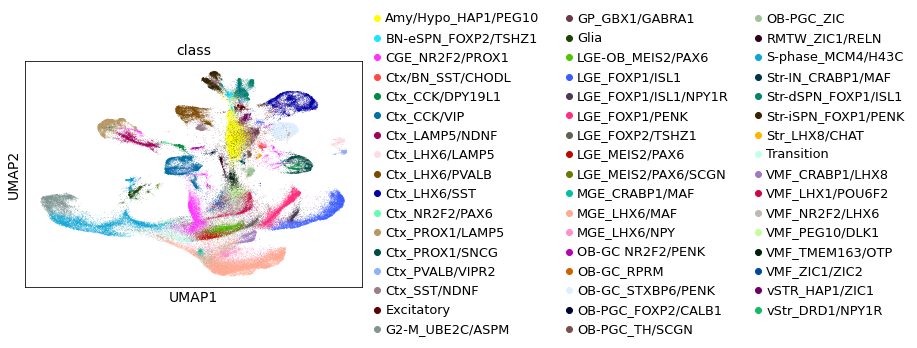

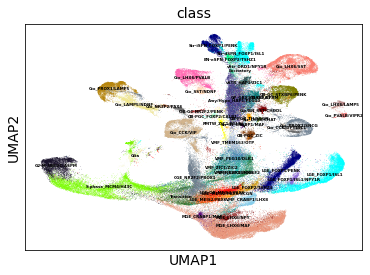

In [86]:
%matplotlib inline
paldict={'CGE_NR2F2/PROX1': 'slategray',
    'G1-phase_SLC1A3/ATP1A1': '#17344c',
    'G2-M_UBE2C/ASPM': '#19122b',
    'LGE_FOXP1/ISL1': 'cyan',
    'LGE_FOXP1/PENK': 'navy',
    'LGE_FOXP2/TSHZ1': 'goldenrod',
    'LGE_MEIS2/PAX6': 'orangered',
    'LGE_MEIS2/PAX6/SCGN': 'orange',
    'LGE-OB_MEIS2/PAX6': 'red',
    'MGE_CRABP1/MAF': 'indigo',
    'MGE_CRABP1/TAC3': 'fuchsia',
    'MGE_LHX6/MAF': 'darksalmon',
    'MGE_LHX6/NPY': 'maroon',
    'RMTW_ZIC1/RELN': 'yellow',
    'S-phase_MCM4/H43C': 'lawngreen',
    'Transition': '#3c7632',
    'VMF_ZIC1/ZIC2': 'teal',
    'VMF_CRABP1/LHX8':'skyblue',
    'VMF_NR2F2/LHX6':'lightseagreen',
    'VMF_LHX1/POU6F2':'seagreen',
    'VMF_TMEM163/OTP':'lightsteelblue',
    'VMF_PEG10/DLK1':'steelblue',
    'LGE_FOXP1/ISL1/NPY1R':'mediumpurple',
    'nan':'white',
    'Str_LHX8/CHAT':'olivedrab',
    'Amy/Hypo_HAP1/PEG10':'darkslateblue',
    'GP_GBX1/GABRA1':'teal',
    'vSTR_HAP1/ZIC1':'darkslategray',
    'Excitatory':'whitesmoke',
    'Ctx_PROX1/LAMP5':'darkgoldenrod', 
    'Ctx_LHX6/LAMP5':'rosybrown', 
    'OB-GC_RPRM':'palegoldenrod', 
    'OB-GC_STXBP6/PENK':'olive', 
    'OB-PGC_FOXP2/CALB1':'aquamarine', 
    'OB-PGC_TH/SCGN':'orange', 
    'OB-PGC_ZIC':'saddlebrown', 
    'Ctx_LHX6/PVALB':'hotpink', 
    'Ctx_PROX1/SNCG':'lightslategray', 
    'Ctx_LHX6/SST':'salmon', 
    'Ctx/BN_SST/CHODL':'maroon',
    'Ctx_CCK/VIP':'tan',
    'Ctx_NR2F2/PAX6':'sienna',
    'Ctx_PVALB/VIPR2':'lightcoral',
    'BN-eSPN_FOXP2/TSHZ1':'springgreen', 
    'Str-dSPN_FOXP1/ISL1':'cyan', 
    'Str-iSPN_FOXP1/PENK':'navy',
    'vStr_DRD1/NPY1R':'violet',
    'Str-IN_CRABP1/MAF':'black',
    'Glia':'lightgoldenrodyellow',
    'OB-GC NR2F2/PENK':'brown',
    'Ctx_LAMP5/NDNF':'khaki',
    'Ctx_SST/NDNF':'peachpuff',
    'Ctx_CCK/DPY19L1':'dimgray'}

sc.pl.umap(adata,color=['class'])
my_pal=[paldict[x] for x in adata.obs['class'].cat.categories]
sc.pl.umap(adata,color=['class'],legend_loc='on data',legend_fontsize=4,palette=my_pal,save='agg_supervised_adult')


In [87]:
adata.uns['regions']=list(adata.obs.region.cat.categories)
adata.uns['classes']=list(adata.obs['class'].cat.categories)

In [88]:
#adata.uns['class_colors']=adata.uns['agg_supervised_name_colors']

In [89]:
adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]


In [ ]:
adata.write_csvs('/wynton/home/ye/mschmitz1/MouseAdultINcsvs/',skip_data=False)

In [90]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)

In [91]:
adata.write('/wynton/home/ye/mschmitz1/MouseAdultInhibitoryNeurons.h5ad')

In [17]:
region_color_dict=dict(zip(adata.obs.region.cat.categories, adata.uns['region_colors']))

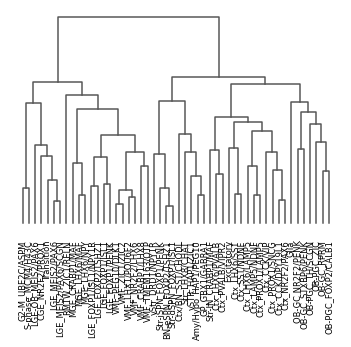

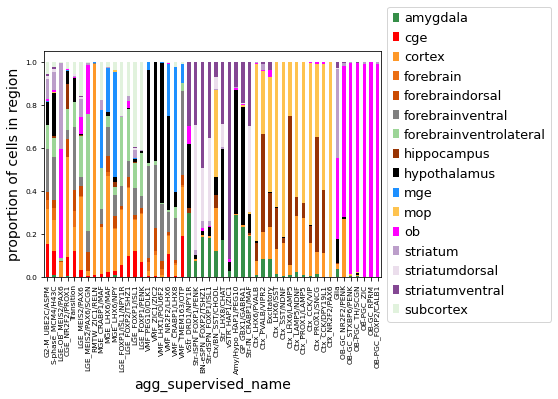

In [24]:
%matplotlib inline
sc.settings.figdir='/wynton/group/ye/mtschmitz/figures/mouseWbGeAdult2/'
scv.settings.figdir='/wynton/group/ye/mtschmitz/figures/mouseWbGeAdult2/'

adata.obs['agg_supervised_name']=adata.obs['class'].astype('category')
sc.tl.dendrogram(adata,groupby='agg_supervised_name')
sc.pl.dendrogram(adata,groupby='agg_supervised_name',save='agg_supervised_name')
df_plot = adata.obs.groupby(['agg_supervised_name', 'region']).size().reset_index().pivot(columns='region', index='agg_supervised_name', values=0).apply(lambda g: g / g.sum(),1)
df_plot=df_plot.loc[adata.uns["dendrogram_agg_supervised_name"]['categories_ordered'],:]
these_colors=[region_color_dict[x] for x in df_plot.columns]
ax = df_plot.plot(kind='bar', legend=False,stacked=True,color=these_colors,fontsize=7.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('proportion of cells in region')
ax.grid(False)
ax.get_figure().savefig(os.path.join(sc.settings.figdir,'supervisedNameRegionsStackBar.pdf'), bbox_inches="tight")


In [ ]:
filepath='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto'
for f,b in zip(obs.file_name.unique(),obs.batch_name.unique()):
    print(f)
    outdir=re.sub('kOut','Out',os.path.join(filepath,f,'outs'))
    cellfile=re.sub('kOut','Out',os.path.join(outdir,'InhibitoryCells.txt'))
    try:
        pd.DataFrame(index=[re.split('_',x)[0]+'-1' for x in obs.loc[obs.file_name.isin([f]),:].index]).to_csv(cellfile,header=False)
        stream = os.popen('/wynton/home/ye/mschmitz1/utils/subset-bam_linux --out-bam '+os.path.join(outdir,b+'_inhibitory.bam')+' --bam '+ os.path.join(outdir,'possorted_genome_bam.bam')+' --cell-barcodes '+ cellfile)
        output = stream.read()
        print(output)
        print('first success')
        print('/wynton/home/ye/mschmitz1/utils/bamtofastq_linux ' + os.path.join(outdir,b+'_inhibitory.bam') + ' '+outdir+'/fastq/' + ' --reads-per-fastq=999999999999')
        stream = os.popen('/wynton/home/ye/mschmitz1/utils/bamtofastq_linux ' + os.path.join(outdir,b+'_inhibitory.bam') + ' '+outdir+'/fastq/' + ' --reads-per-fastq=999999999999')
        output = stream.read()
        print(output)
        print('double success')
        [os.rename(os.path.join(outdir+'/fastq/',y,x),os.path.join(outdir+'/fastq/',y,re.sub('bamtofastq',b,x))) for y in os.listdir(outdir+'/fastq/') for x in os.listdir(outdir+'/fastq/'+y)]
            except:
        pass

In [90]:
filepath='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto'
for f,b in zip(obs.file_name.unique(),obs.batch_name.unique()):
    print(f)
    outdir=re.sub('kOut','Out',os.path.join(filepath,f,'outs'))
    cellfile=re.sub('kOut','Out',os.path.join(outdir,'InhibitoryCells.txt'))
    [os.rename(os.path.join(outdir+'/fastq/',y,x),os.path.join(outdir+'/fastq/',y,re.sub('bamtofastq',b,x))) for y in os.listdir(outdir+'/fastq/') for x in os.listdir(outdir+'/fastq/'+y)]

E90-2019_V1_kOut
PEC_Yale_SingleCellRNAseq_RMB691_DFC_kOut


FileNotFoundError: [Errno 2] No such file or directory: '/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/PEC_Yale_SingleCellRNAseq_RMB691_DFC_Out/outs/fastq/'

In [ ]:
'Mac2_V1' in adata.obs.batch_name

In [ ]:
list(adata.obs.batch_name.unique())

In [ ]:
adata.obs

In [ ]:
filedf=pd.DataFrame(list(adata.obs.groupby(['batch_name','file_name','region','timepoint']).sum().dropna().index.to_numpy()))

In [ ]:
filedf.index=filedf[1]

In [ ]:
filedf

In [ ]:
l=[]
filepath='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto'
for x in os.listdir(filepath):
    if os.path.isdir(os.path.join(filepath,x)) & ('_Out' in x):
        try:
            for y in os.listdir(os.path.join(filepath,x,'outs','fastq')):
                fc=re.split('_',y)
                fc=fc[-1]
                print(fc)
                for z in os.listdir(os.path.join(filepath,x,'outs','fastq',y)):
                    print(os.path.join(filepath,x,'outs','fastq',y,z))
                    print(os.path.join(filepath,x,'outs','fastq',y,fc+'_'+z))
                    #os.rename(os.path.join(filepath,x,'outs','fastq',y,z),os.path.join(filepath,x,'outs','fastq',y,fc+'_'+z))
                    #os.rename(os.path.join(filepath,x,'outs','fastq',y,z),'/wynton/group/ye/mtschmitz/macaquedevbrain/INfastqs/'+z)
        except:
            print('FAIL',os.path.join(filepath,x,'outs','fastq'))


In [ ]:
l=[]
filepath='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto'
for x in filedf[1]:
    origx=x
    x=re.sub('kOut','Out',x)
    if 'PEC' in x:
        continue
    for y in os.listdir(os.path.join(filepath,x,'outs','fastq')):
        print(os.path.join(filepath,x,'outs','fastq',y))
        print(os.listdir(os.path.join(filepath,x,'outs','fastq',y)))
        for z in os.listdir(os.path.join(filepath,x,'outs','fastq',y)):
            print(os.path.join(filepath,x,'outs','fastq',y,z))
            l.append([x,os.path.join(filepath,x,'outs','fastq',y,z)]+list(filedf.loc[origx,:]))


In [ ]:
df=pd.DataFrame(l)
df

In [182]:
df[1]=[re.split('/',x)[-1] for x in df[1]]

In [2]:
df.columns

NameError: name 'df' is not defined

In [ ]:
#unrelated mouse dataset taken from bams
filepath='/wynton/group/ye/mtschmitz/mousefastqpool/PRJNA637987_lamanno_devmouse'
#To run with kalliso use read schema 1,0,0:2,0,0:0,0,0
for x in os.listdir(filepath):
    try:
        if os.path.isdir(os.path.join(filepath,x)):
            for y in os.listdir(os.path.join(filepath,x)):
                print(os.path.join(filepath,x,y))
                l=re.split('_',y)
                for z in os.listdir(os.path.join(filepath,x,y)):
                    print(os.path.join(filepath,x,y,z))
                    print(os.path.join(filepath,re.sub('bamtofastq',x+'__'+l[-1],z)))
                    os.rename(os.path.join(filepath,x,y,z),os.path.join(filepath,re.sub('bamtofastq',x+'__'+l[-1],z)))
    except:
        pass
    
"""
filepath='/wynton/group/ye/mtschmitz/mousefastqpool/PRJNA637987_lamanno_devmouse'
#To run with kalliso use read schema 1,0,0:2,0,0:0,0,0
for x in os.listdir(filepath):
    if 'fastq.gz' in x:
        #print(x)
        #print(re.split('_',re.sub('.fastq.gz','',x)))
        l=re.split('_',re.sub('.fastq.gz','',x))
        print(os.path.join(filepath,x),os.path.join(filepath,re.sub('L[0-9]+','L'+l[-1],x)))
        os.rename(os.path.join(filepath,x),os.path.join(filepath,re.sub('L[0-9]+','L'+l[-1],x)))
"""

In [2]:
f = open('/wynton/group/ye/mtschmitz/refdata2/mm10/Mus_musculus.GRCm38.dna.primary_assembly.fa', "r")
l=f.readlines()




In [3]:
import tqdm
chrstring=[]
for x in tqdm.tqdm(l):
    if x[0] != '>':
        #if x != 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN\n':
        chrstring[-1].append(x[:-1])
    else:
        chrstring.append([])


100%|██████████| 45514629/45514629 [00:26<00:00, 1720123.85it/s]


In [4]:
chrstringcat=[]
for x in chrstring:
    chrstringcat.append(''.join(x))

In [5]:
import re
broken=[]
for x in tqdm.tqdm(chrstringcat):
    broken.append(re.split('GAGCTC',x))

100%|██████████| 66/66 [00:11<00:00,  5.82it/s]


In [6]:
len(chrstring[0])

3257867

In [7]:
flatlist=[len(item) for sublist in tqdm.tqdm(broken) for item in sublist]    

100%|██████████| 66/66 [00:00<00:00, 286.48it/s]


In [8]:
print(len(flatlist))

664895


In [9]:
flatlist[2]

4012

Text(0, 0.5, '# fragments')

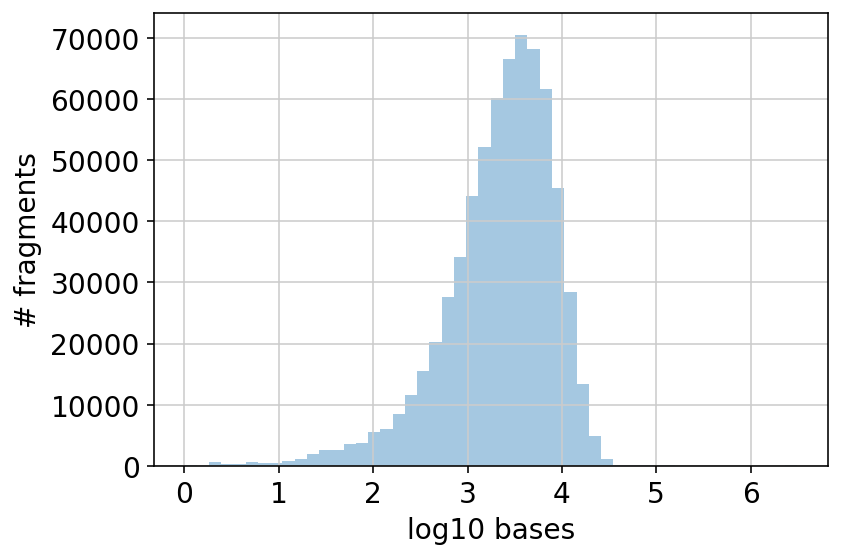

In [11]:
%matplotlib inline
import seaborn
seaborn.distplot(np.log10(np.array(flatlist)+1),kde=False)
plt.xlabel('log10 bases')
plt.ylabel('# fragments')

In [28]:
logvals=np.log10(np.array(flatlist)+1)
h=np.histogram(logvals,bins=int((np.max(logvals)-np.min(logvals))/.1)+1)
10**h[1]


array([1.00000000e+00, 1.25857776e+00, 1.58401797e+00, 1.99360979e+00,
       2.50911294e+00, 3.15791374e+00, 3.97447999e+00, 5.00219211e+00,
       6.29564773e+00, 7.92356221e+00, 9.97241916e+00, 1.25510649e+01,
       1.57964912e+01, 1.98811125e+01, 2.50219259e+01, 3.14920394e+01,
       3.96351804e+01, 4.98839565e+01, 6.27828381e+01, 7.90170836e+01,
       9.94491439e+01, 1.25164481e+02, 1.57529231e+02, 1.98262787e+02,
       2.49529134e+02, 3.14051818e+02, 3.95258632e+02, 4.97463723e+02,
       6.26096777e+02, 7.87991478e+02, 9.91748548e+02, 1.24819266e+03,
       1.57094752e+03, 1.97715961e+03, 2.48840911e+03, 3.13185636e+03,
       3.94168476e+03, 4.96091677e+03, 6.24369950e+03, 7.85818132e+03,
       9.89013222e+03, 1.24475004e+04, 1.56661472e+04, 1.97170644e+04,
       2.48154587e+04, 3.12321844e+04, 3.93081326e+04, 4.94723414e+04,
       6.22647885e+04, 7.83650779e+04, 9.86285441e+04, 1.24131692e+05,
       1.56229386e+05, 1.96626831e+05, 2.47470156e+05, 3.11460434e+05,
      

In [36]:
h=np.histogram(flatlist,bins=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,1000000,10000000])
pd.DataFrame(h[::-1]).T

0         1
0          0.0  151683.0
1       1000.0  116957.0
2       2000.0   87272.0
3       3000.0   67034.0
4       4000.0   52767.0
5       5000.0   40383.0
6       6000.0   32440.0
7       7000.0   26099.0
8       8000.0   19987.0
9       9000.0   14948.0
10     10000.0   11774.0
11     11000.0   43531.0
12   1000000.0      20.0
13  10000000.0       NaN